<a href="https://colab.research.google.com/github/simonefmr/teste/blob/main/ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pós Graduação Ciência de Dados - PUC Rio**
# **MVP Sprint I: Análise de Dados e Boas Práticas**
## Aluna: Simone de Fátima Marques Ramos

## **1. Introdução**

Todos os anos, o número de clientes bancarizados aumenta no Brasil. O uso de contas para recebimento de pagamento movimentou as instituições financeiras na década de 2000. Nos últimos anos, com o avanço das fintechs, ficou fácil e barato ter uma conta corrente e contar com diversos produtos, sem burocracia ou as temidas filas.

Cerca de 16,6 milhões de brasileiros abriram contas em instituições financeiras entre 2020 e 2021, chegando a um total de 182,2 milhões em dezembro de 2021. Em 2002 o país tinha 28% de bancarizados, em 2017 já representava 70% e em 2022 atingiu 84%. Esse avanço, nos últimos anos, é associado ao recebimento do auxílio emergencial (exigência de recebimento em conta) e ao avanço no uso do Pix como meio de pagamento.

O Banco Central atua como órgão regulador de instituições financeiras, bancárias, caixas econômicas, cooperativas de crédito, bancos de câmbio etc. Ele define uma série de exigências e normas e monitora as instituições reguladas para seu correto cumprimento.

Uma ferramenta utilizada nesta função é a Ouvidoria do Bacen, onde são recebidas reclamações dos clientes e usuários de instituições financeiras e o Bacen intermedia para melhor solução do conflito. Através destes registros é feito o Ranking Bacen.

O  Ranking Bacen é formado a partir das reclamações do público registradas nos canais de atendimento do Banco Central (BC): internet, correspondência, presencialmente ou telefone (145). As demandas são analisadas de forma amostral pelo BC.

Participam do Ranking: bancos (comerciais, múltiplos, cooperativos, de investimentos), sociedades de crédito, financiamento e investimento (SCFI), instituições de pagamento e administradoras de consórcio.

São divulgados três arquivos, no formato CSV, com os seguintes detalhamentos:

I- Bancos e financeiras - Reclamações e quantidades de clientes por instituição financeira:
Apresenta as quantidades de reclamações e clientes, por instituição financeira, referentes ao mês
selecionado.

II- Bancos e financeiras - Irregularidades por instituição financeira:
Apresenta as quantidades de reclamações, por irregularidade e instituição financeira, referentes ao
mês selecionado.

III- Bancos e financeiras - Tabela de irregularidades:
Apresenta a tabela de irregularidades referente ao mês selecionado.

Neste projeto, irei abordar apenas os dados das **Irregularidades por instituição financeira (II)**.

### **1.1. Problema de aprendizado supervisionado ou não supervisionado e Hipóteses sobre o problema**

Fazem parte do ranking as reclamações que foram analisadas e encerradas como:

Reclamações reguladas procedentes: casos em que houve sinal de descumprimento de lei ou norma pela instituição financeira no período indicado.
Reclamações reguladas – outras: casos em que não houve sinal de descumprimento de lei ou norma pela instituição financeira no período indicado (inclui as reclamações encerradas como improcedentes e não conclusivas).
Reclamações não reguladas: casos que não são tratados por lei ou norma expedida pelo Banco Central e não são sujeitos a sua supervisão.
Total de reclamações: total de reclamações reguladas procedentes, reclamações reguladas – outras e reclamações não reguladas.

Neste projeto analizarei apenas o **primeiro trimestre de 2023**. Sem base histórica, trataremos como um problema de **aprendizado não supervisionado**, sendo o objetivo entender as possíveis relações entre os dados apresentados.

### **1.2. Definição do Problema** 


O alto índice de reclamações ou reincidência das mesmas, podem levar o Banco Central a multar as instituições financeiras ou aplicar outras ferramentas de supervisão, como termos de compromisso, acordos de leniência, e medidas coercitivas e acautelatórias.

As instituições são classificadas pela ordem decrescente do índice de reclamações, ou seja, da mais reclamada para a menos reclamada, levando-se em consideração o número de clientes ativos de cada uma. Neste projeto não farei a associação com o número de clientes. Será abordado apenas o número absoluto de ocorrências registradas e seu respectivo resultado.

As Reclamações reguladas – outras e as Reclamações não reguladas são divulgadas, porém não influenciam na posição das instituições no ranking.

No processo de análise, pode ser identificada mais de uma irregularidade para uma mesma reclamação. Nesse caso, cada irregularidade conta como uma ocorrência para cálculo do Ranking de Reclamações.

Tentar entender as origens das reclamações é essencial para monitoramento do correto funcionamento do sistema financeiro pelo Bacen, assim como pelas instituições financeiras, que buscam atendimento de qualidade e não desejam ter suas atividades limitadas ou restritas por força de sanção.

## **2. Importação de pacotes e bibliotecas**

In [140]:
# Importando bibliotecas e pacotes que serão utilizados na análise

# Importação de Bibliotecas
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch, Polygon
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
import plotly.express as px
from pandas import set_option
from pandas.plotting import scatter_matrix

from IPython.utils.sysinfo import encoding

# para tratamento de data
import datetime

# para tratamento de missings
import missingno as ms 

# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

## transformações numéricas
import unicodedata
from sklearn.model_selection import train_test_split # para divisão de treino e teste
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.preprocessing import StandardScaler # para padronização

## transformações categóricas
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [141]:
# Versões das Bibliotecas utilizadas

pd_pd = pd.__version__
np_np = np.__version__
sns_sns = sns.__version__

print('Versões utilizadas na análise:')
print('Pandas = '+pd_pd)
print('Numpy = '+np_np)
print('Seaborn = '+sns_sns)

Versões utilizadas na análise:
Pandas = 1.5.3
Numpy = 1.22.4
Seaborn = 0.12.2


## **3. Carregamento dos dados**

Os dados estão disponíveis no site do Banco Central e são publicados desde 2014. 
O relatório trimestral é divulgado no formato CSV, disponível para download, não sendo possível sua consulta direta no site. 

https://www3.bcb.gov.br/ranking/historico.do


In [142]:
# Definindo a url dos dados

url = 'https://raw.githubusercontent.com/simonefmr/teste/main/ranking_irregularidades.csv'

In [143]:
# Carregando o dataset através da url do github

df = pd.read_csv(url, sep=';', encoding='ISO-8859-1')

### **3.1. Condições ou restrições impostas para selecionar os dados**

Não houve dificuldade de carregamento dos dados. Foi preciso ajustar o separador e o encoding para correta leitura do dataset.

### **3.2. Definição dos atributos**

In [144]:
# labels dos atributos do dataset

df.columns

Index(['Ano', 'Trimestre', 'Categoria', 'Tipo', 'CNPJ IF',
       'Instituição financeira', 'Irregularidade',
       'Quantidade de reclamações reguladas procedentes',
       'Quantidade de reclamações reguladas - outras',
       'Quantidade de reclamações não reguladas',
       'Quantidade total de reclamações', 'Unnamed: 11'],
      dtype='object')

**Definindo o que cada atributo representa**

**Ano:** Ano de referência.

**Trimestre:** Trimestre de referência

**Categoria Listagem do ranking:** Mais de dois milhões de clientes ou Menos de dois milhões de clientes.

**Tipo:** Tipo de instituição: Bancos e financeiras ou
Conglomerados.

**CNPJ IF:** CNPJ da instituição financeira (para bancos e financeiras). *Para conglomerados, esse campo não é preenchido.*

**Instituição financeira:** Nome da instituição financeira ou do conglomerado.

**Irregularidade:** Nome da irregularidade.

**Quantidade de reclamações reguladas procedentes:** Quantidade de reclamações reguladas procedentes,
associadas à irregularidade, encerradas no mês de
referência.

**Quantidade de reclamações reguladas - outras:** Quantidade de reclamações reguladas – outras, associadas à irregularidade, encerradas no mês de referência (Não procedentes).

**Quantidade de reclamações não reguladas:** Quantidade de reclamações não reguladas, associadas à irregularidade, encerradas no mês de referência (Irreguladas são reclamações que não tem base regulamentada ou que sua regulamentação não é de competência do Banco Central.

**Quantidade total de reclamações:** Quantidade total de reclamações, associadas à irregularidade, encerradas no mês de referência.

## **4. Análise de Dados**

### **4.1. Limpeza preliminar dos dados**

In [145]:
# Eliminando a coluna "Unnamed" que não possui dados

df.drop(columns=['Unnamed: 11'], inplace=True)

In [146]:
# Busco informações sobre contagem de não nulos e tipo de cada atributo

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3515 entries, 0 to 3514
Data columns (total 11 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   Ano                                              3515 non-null   int64 
 1   Trimestre                                        3515 non-null   object
 2   Categoria                                        3515 non-null   object
 3   Tipo                                             3515 non-null   object
 4   CNPJ IF                                          3515 non-null   object
 5   Instituição financeira                           3515 non-null   object
 6   Irregularidade                                   3515 non-null   object
 7   Quantidade de reclamações reguladas procedentes  3515 non-null   int64 
 8   Quantidade de reclamações reguladas - outras     3515 non-null   int64 
 9   Quantidade de reclamações não reguladas  

In [147]:
# Vamos excluir as colunas "Tipo" e "CNPJ IF" pois não apresentam dados
# relevantes para a análise

df.drop(columns=['Tipo', 'CNPJ IF'], inplace=True)

In [148]:
print(df.columns)

Index(['Ano', 'Trimestre', 'Categoria', 'Instituição financeira',
       'Irregularidade', 'Quantidade de reclamações reguladas procedentes',
       'Quantidade de reclamações reguladas - outras',
       'Quantidade de reclamações não reguladas',
       'Quantidade total de reclamações'],
      dtype='object')


In [149]:
# Classificando a coluna "Ano" como data

df['Ano'] = pd.to_datetime(df['Ano'], format='%Y')
df.dtypes

Ano                                                datetime64[ns]
Trimestre                                                  object
Categoria                                                  object
Instituição financeira                                     object
Irregularidade                                             object
Quantidade de reclamações reguladas procedentes             int64
Quantidade de reclamações reguladas - outras                int64
Quantidade de reclamações não reguladas                     int64
Quantidade total de reclamações                             int64
dtype: object

In [150]:
# Exibindo as primeiras linhas verifico que o dataset foi carregado corretamente

df.head()

,Ano,Trimestre,Categoria,Instituição financeira,Irregularidade,Quantidade de reclamações reguladas procedentes,Quantidade de reclamações reguladas - outras,Quantidade de reclamações não reguladas,Quantidade total de reclamações
0,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",ABC-BRASIL (conglomerado),Cobrança irregular de tarifa relacionada a con...,0,1,0,1
1,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",ABC-BRASIL (conglomerado),"Débito em conta não autorizado pelo cliente, o...",0,1,0,1
2,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",ABC-BRASIL (conglomerado),Insatisfação com a resposta recebida da instit...,0,2,0,2
3,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",ABC-BRASIL (conglomerado),Insatisfação com o atendimento prestado pelo S...,0,0,1,1
4,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",ABC-BRASIL (conglomerado),Irregularidades relacionadas ao acompanhamento...,1,0,0,1


In [151]:
# Exibindo as últimas linhas

df.tail()

,Ano,Trimestre,Categoria,Instituição financeira,Irregularidade,Quantidade de reclamações reguladas procedentes,Quantidade de reclamações reguladas - outras,Quantidade de reclamações não reguladas,Quantidade total de reclamações
3510,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",YAMAHA MOTOR (conglomerado),Irregularidades relacionadas ao fornecimento d...,0,1,0,1
3511,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",YAMAHA MOTOR (conglomerado),Irregularidades relacionadas ao fornecimento d...,0,2,0,2
3512,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",YAMAHA MOTOR (conglomerado),"Irregularidades relativas a integridade, confi...",1,2,0,3
3513,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",YAMAHA MOTOR (conglomerado),Reclamações relacionadas a assuntos diversos,0,0,2,2
3514,2023-01-01,1º,"Demais Bancos, Financeiras e Instituições de P...",YAMAHA MOTOR (conglomerado),Renegociação de dívida (exceto cartão de crédito),0,0,1,1


### **4.2. Análise Descritiva**

In [152]:
# Verificando o formato do dataset

df.shape

(3515, 9)

Foram registradas reclamações de 3.515 Instituições diferentes. A média por instituição foi de 17,27, sendo o maior número de 810 para uma mesma instituição.
A média de reclamações procedentes foi de 5,42 por instituição reclamada e o maior valor observado foi de 395 para uma mesma instituição.
Importante ressaltar que só constam no relatório instituições que tiveram reclamações registradas no período, por isso o número de mínimo em "Quantidade total de reclamações" é 1.

In [154]:
# Agrupando as instâncias por instituição financeira

df_groupby = df.groupby('Instituição financeira').sum()
df_groupby.shape

(161, 4)

In [191]:
# Resumo estatístico dos dados completos
df_groupby.describe()

,Quantidade de reclamações reguladas procedentes,Quantidade de reclamações reguladas - outras,Quantidade de reclamações não reguladas,Quantidade total de reclamações
count,161.000000,161.000000,161.000000,161.000000
mean,118.496894,182.453416,76.279503,377.229814
std,333.351262,575.986837,278.144279,1154.693180
min,0.000000,0.000000,0.000000,1.000000
25%,1.000000,2.000000,1.000000,5.000000
50%,5.000000,9.000000,4.000000,18.000000
75%,32.000000,51.000000,22.000000,121.000000
max,2390.000000,3750.000000,1982.000000,7785.000000


In [155]:
# Calculando a média, mediana e moda dos dados
mean = np.mean(df_groupby['Quantidade de reclamações reguladas procedentes'])
median = np.median(df['Quantidade de reclamações reguladas procedentes'])
mode = np.round(df['Quantidade de reclamações reguladas procedentes'])

print(f'Média: {mean:.2f}')
print(f'Mediana: {median:.2f}')
print(f'Moda: {mode}')

Média: 118.50
Mediana: 1.00
Moda: 0       0
1       0
2       0
3       0
4       1
       ..
3510    0
3511    0
3512    1
3513    0
3514    0
Name: Quantidade de reclamações reguladas procedentes, Length: 3515, dtype: int64


Agrupando por **"Instituição financeira"**, observamos que o número médio de reclamações é de 118,50. Entretanto, a mediana, que apresenta o valor central dos dados, apresenta valor 1 (metade das instituições teriam uma ou nenhuma reclamação) e o maior valor observado (moda) é 0. Portanto, podemos afirmar que poucas instituições tem contribuído com o elevado número de reclamações. O maior valor observado é de 2390.  

In [156]:
print(df_groupby)

                                                    Quantidade de reclamações reguladas procedentes  \
Instituição financeira                                                                                
ABC-BRASIL (conglomerado)                                                                         6   
ACESSO SOLUÇÕES DE PAGAMENTO S.A. - INSTITUIÇÃO...                                              154   
ACG INSTITUIÇÃO DE PAGAMENTO S.A.                                                                 2   
AFINZ (conglomerado)                                                                             16   
AGIBANK (conglomerado)                                                                          184   
...                                                                                             ...   
VR (conglomerado)                                                                                 7   
WESTERN UNION (conglomerado)                                             

Existem 3515 registros de infrações reclamadas para diversas instituições. Quando agrupamos por "Instituição financeira", obtemos 161 linhas, ou seja, **161 instituições diferentes** tiveram reclamações registradas no período.

In [157]:
# Resumo estatístico das instituições classificadas pelo Bacen como 
# "Top 15" (com maior volume de depósitos totais).

df[df['Categoria']=='Top 15 - Bancos, Financeiras e Instituições de Pagamento'].describe()

,Quantidade de reclamações reguladas procedentes,Quantidade de reclamações reguladas - outras,Quantidade de reclamações não reguladas,Quantidade total de reclamações
count,1317.000000,1317.000000,1317.000000,1317.000000
mean,10.294609,17.311314,7.675778,35.281701
std,29.942342,42.570238,30.840512,69.800075
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,2.000000
50%,1.000000,2.000000,0.000000,8.000000
75%,7.000000,13.000000,1.000000,33.000000
max,395.000000,439.000000,401.000000,810.000000


In [158]:
# Resumo estatístico das demais instituições

df[df['Categoria']=='Demais Bancos, Financeiras e Instituições de Pagamento'].describe()

,Quantidade de reclamações reguladas procedentes,Quantidade de reclamações reguladas - outras,Quantidade de reclamações não reguladas,Quantidade total de reclamações
count,2198.000000,2198.000000,2198.000000,2198.000000
mean,2.511374,2.991811,0.988171,6.491356
std,13.134215,10.041241,3.283432,19.712722
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,0.000000,2.000000
75%,1.000000,2.000000,1.000000,5.000000
max,296.000000,256.000000,54.000000,465.000000


Por ter o maior volume de depósitos totais no país, as instituições "Top 15" também apresentam o maior volume de clientes e, consequentemente, estão mais sujeitas à receber reclamações. A média de reclamações totais é de 35,28 nas "Top 15" e de 6,49 nas demais instituições.

In [159]:
# Exibindo a Correlação de Pearson

correlacao = df.corr(method='pearson')
print(correlacao)

                                                 Quantidade de reclamações reguladas procedentes  \
Quantidade de reclamações reguladas procedentes                                         1.000000   
Quantidade de reclamações reguladas - outras                                            0.612956   
Quantidade de reclamações não reguladas                                                -0.045877   
Quantidade total de reclamações                                                         0.793462   

                                                 Quantidade de reclamações reguladas - outras  \
Quantidade de reclamações reguladas procedentes                                      0.612956   
Quantidade de reclamações reguladas - outras                                         1.000000   
Quantidade de reclamações não reguladas                                             -0.053781   
Quantidade total de reclamações                                                      0.844830   

             

Pelo conceito de **Correlação de Pearson**, existiria uma correlação moderada entre novas reclamações e as reclamações não reguladas. As reclamações procedentes e improcedentes apresentariam alta correlação. 
Entretanto, como a coluna "Quantidade total de reclamações" representa a soma das outras três, é possível que essa correlação possa apresentar uma visão distorcida da relação entre as variáveis.
Precisaríamos de uma linha temporal mais consistente para percebermos esta relação no problema de negócio.

Considerei que o **heatmap** não era uma boa opção neste caso. A relação entre as variáveis está diretamente relacionada ao atributo "Quantidade total de reclamações" e o heatmap não fornece muitas informações úteis sobre as variáveis.
Como a intenção é explorar a relação entre quantidade total de reclamações e reclamações procedentes, então é melhor visualizar essa relação diretamente em um gráfico de dispersão ou em um gráfico de barras. 

In [160]:
# Separando colunas do tipo "int64"
int_cols = df.select_dtypes(include='int64').columns

# Calculando a soma destas colunas
df_sum = df[int_cols].sum()
print(df_sum)



Quantidade de reclamações reguladas procedentes    19078
Quantidade de reclamações reguladas - outras       29375
Quantidade de reclamações não reguladas            12281
Quantidade total de reclamações                    60734
dtype: int64


Aqui temos o **somatório** de todas as reclamações registradas. Dos 3515 protocolos abertos, foi gerado um total de 60734 reclamações. Destas, 19078 foram analisadas como procedentes, 29375 improcedentes e 12281 não são objeto de tratamento do Bacen, seja pela ausência de regulamentação ou por não ser regulada pelo Bacen.
Neste caso de não reguladas, podemos dar o exemplo de uma reclamação relacionada à indenização de sinistro de um seguro auto, contratado junto à um banco. Neste caso, a reguladora de seguros é a Susep, não o Bacen. A demanda é encerrada como "Reclamação não regulada".

In [161]:
# Realizando algumas separações de dataset para melhor visualização e análises

# Quantidade total de reclamações
df_categoria_qtd_total = df.groupby(by=['Categoria'], as_index=False)['Quantidade total de reclamações'].sum()
print(df_categoria_qtd_total)


                                           Categoria  \
0  Demais Bancos, Financeiras e Instituições de P...   
1  Top 15 - Bancos, Financeiras e Instituições de...   

   Quantidade total de reclamações  
0                            14268  
1                            46466  


In [162]:
# Quantidade total de reclamações consideradas procedentes

df_categoria_qtd_procedente = df.groupby(by=['Categoria'], as_index=False)['Quantidade de reclamações reguladas procedentes'].sum()
print(df_categoria_qtd_procedente)

                                           Categoria  \
0  Demais Bancos, Financeiras e Instituições de P...   
1  Top 15 - Bancos, Financeiras e Instituições de...   

   Quantidade de reclamações reguladas procedentes  
0                                             5520  
1                                            13558  


In [163]:
# Número de irregularidades apresentadas com respectiva contagem
# Foram 174 tipos de irregularidades denunciadas no Bacen 

df['Irregularidade'].value_counts()



Insatisfação com a resposta recebida da instituição financeira referente à reclamação registrada no BCB                                                                    68
Renegociação de dívida (exceto cartão de crédito)                                                                                                                          67
Irregularidades relacionadas ao fornecimento de documentos relativos a operação de crédito, exceto para liquidação antecipada e descritivo do crédito.                     67
Irregularidades relacionadas ao Sistema de Informações de Crédito do Banco Central (SCR)                                                                                   66
Insatisfação com o atendimento prestado pelo SAC ou Central de Relacionamento                                                                                              59
                                                                                                                                  

In [164]:
# Buscando as 15 instituições que mais tiveram irregularidades consideradas procedentes

df_15_maiores_if_reclamadas = df.groupby('Instituição financeira')['Quantidade de reclamações reguladas procedentes'].sum().sort_values(ascending=False).head(15)
print(df_15_maiores_if_reclamadas)

Instituição financeira
BRADESCO (conglomerado)                                         2390
CAIXA ECONÔMICA FEDERAL (conglomerado)                          1687
BTG PACTUAL/BANCO PAN (conglomerado)                            1608
ITAU (conglomerado)                                             1565
SANTANDER (conglomerado)                                        1050
FACTA FINANCEIRA S.A. - CRÉDITO FINANCIAMENTO E INVESTIMENTO     845
INTER (conglomerado)                                             825
BMG (conglomerado)                                               813
PAGBANK-PAGSEGURO (conglomerado)                                 781
C6 BANK (conglomerado)                                           733
MERCADO CRÉDITO (conglomerado)                                   648
BB (conglomerado)                                                637
ORIGINAL (conglomerado)                                          535
NUBANK (conglomerado)                                            482
MERCANTIL D

In [165]:
# Buscando as 15 maiores irregularidades consideradas procedentes

df_15_maiores_irregularidades = df.groupby('Irregularidade')['Quantidade de reclamações reguladas procedentes'].sum().sort_values(ascending=False).head(15)
print(df_15_maiores_irregularidades)

Irregularidade
Irregularidades relativas a integridade, confiabilidade, segurança, sigilo ou legitimidade das operações e serviços relacionados a cartões de crédito                                                                                            2952
Oferta ou prestação de informação sobre crédito consignado de forma inadequada                                                                                                                                                                   1191
Irregularidades relativas a integridade, confiabilidade, segurança, sigilo ou legitimidade das operações e serviços, exceto as relacionadas a cartão de crédito, cartão de débito, internet banking, ATM, credenciadora e operação de crédito    1127
Irregularidades relativas a integridade, confiabilidade, segurança, sigilo ou legitimidade dos serviços relacionados a operações de crédito, exceto consignado                                                                                    784
O

**Reclamações procedentes**
Dentre os tipos de irregularidade, busquei as 15 que mais foram consideradas procedentes, podendo destacar irregularidade relativas à integridade, confiabilidade, segurança, sigilo ou legitimidade de operações e serviços e à oferta ou prestação de informação inadequada. 
De 173 tipos listados nas reclamações procedentes, as 6 primeiras representam um total de 7351 registros, cerca de 38,53% do total. Isto representa um número expressivo. Podemos dizer que estas seriam as maiores fragilidades das instituições financeiras em relação ao atendimento adequado dos clientes. 

**Avaliação Inicial**

Em um outro relatório do Bacen (Reclamações e Quantidade de Clientes), informa-se que no 1ºT/2023, o total de clientes ativos em todas as instituições foi de  aproximadamente 356,2 milhões. Os bancos classificados como "Top 15" possuem aproximadamente 266 milhões de clientes ativos - cerca de 74,68% (clientes podem manter contas e/ou operações em diversas instituições).  

Das 60734 reclamações realizadas, 71,06% foram direcionadas às instituições "Top 15", número condizente com o percentual de clientes de sua base. 19078 reclamações foram consideradas procedentes (cerca de 31,41%).

### **4.3. Tratamento de Missings**

In [166]:
# Contagem de nulos

df.isnull().sum()

Ano                                                0
Trimestre                                          0
Categoria                                          0
Instituição financeira                             0
Irregularidade                                     0
Quantidade de reclamações reguladas procedentes    0
Quantidade de reclamações reguladas - outras       0
Quantidade de reclamações não reguladas            0
Quantidade total de reclamações                    0
dtype: int64

<Axes: >

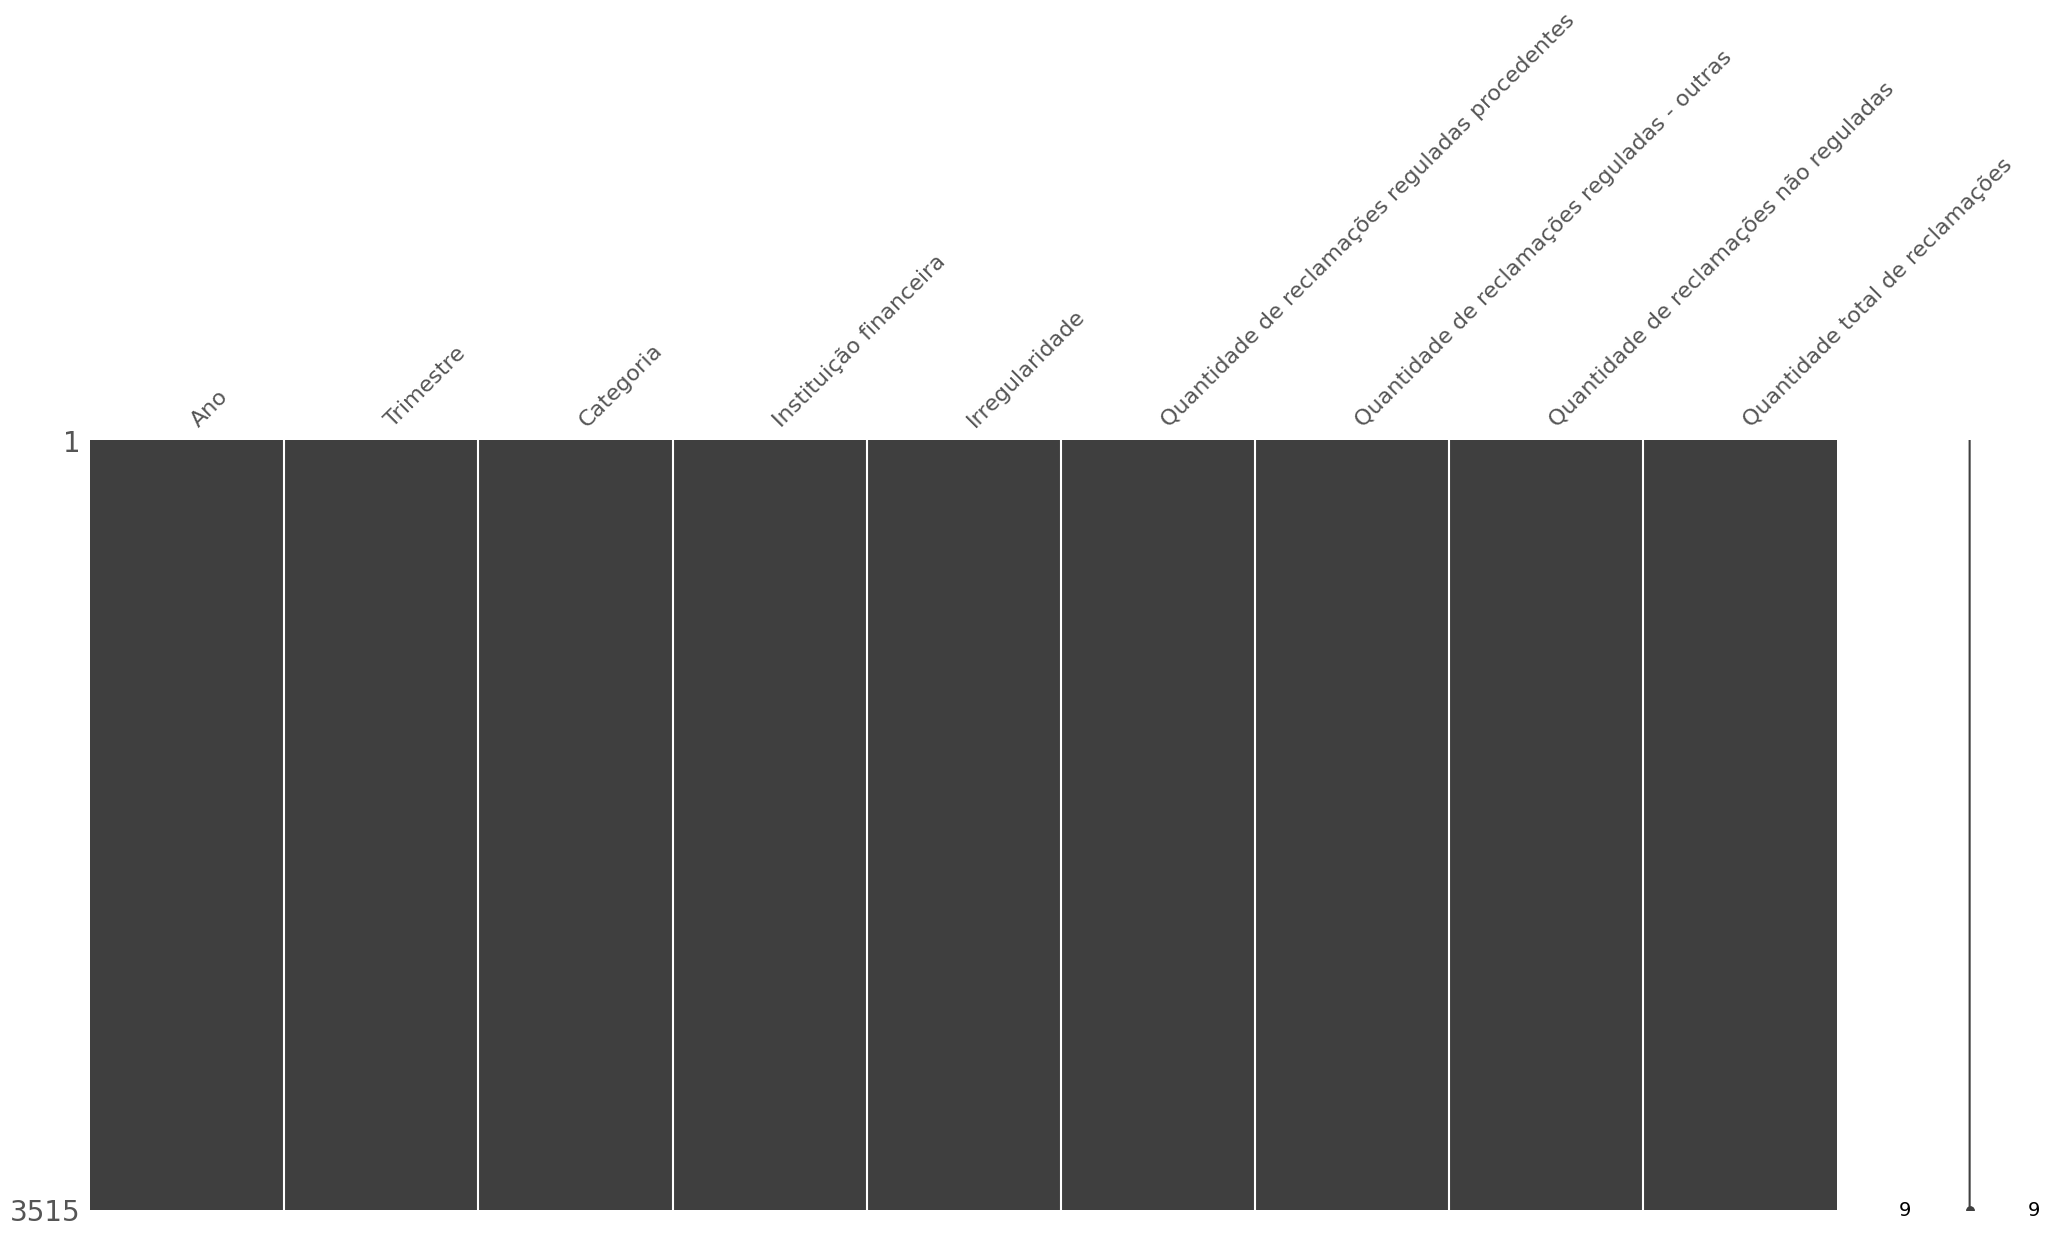

In [167]:
# Exibindo visualização matricial que evidencia a ausência de nulidade do dataset

ms.matrix(df)

**Missings e Zeros**

Neste caso não será preciso fazer ajustes de faltantes (exclusão ou substituição) pois o dataset está totalmente preenchido.

Cabe ressaltar que a existência de zeros é o desejável. Não convém substituir os valores por médias ou medianas pois as instituições financeiras buscam o menor número de reclamações tanto para evitar as sanções quanto para reter e fidelizar seus clientes.

Muitas instituições não foram citadas neste relatório pois não tiveram nenhum tipo de reclamação, podendo ter constado em outro trimestre apurado. O registro das informações foi feito de forma consistente e observação de máximos e mínimos refletem a realidade, não sendo considerados outliers.



## **5. Visualizações**

In [168]:
# Defini a paleta de cores utilizando referências da logo do Bacen e de alguns
# elementos mais vibrantes na página

cores = ['#1A3B5C', '#035B73', '#405B7E', '#CFAF96', '#98796B', '#DC7E3C']

# exibe o mapa de cores
display(cores)

# define uma cor default
corDefault = cores[1]

# Carrega uma folha de estilos (opcional - questões estéticas)
plt.style.use("ggplot")

# Modifica mais alguns parâmetros gráficos (opcional - questões estéticas)
plt.rc("axes", facecolor="#fafafa", grid = True)
plt.rc("grid", color = "#f0f0f0")
plt.rc("axes", edgecolor="#cccccc", lw=0.1)

['#1A3B5C', '#035B73', '#405B7E', '#CFAF96', '#98796B', '#DC7E3C']

In [169]:
df.shape

(3515, 9)

### **5.1. Gráfico de barras simples**

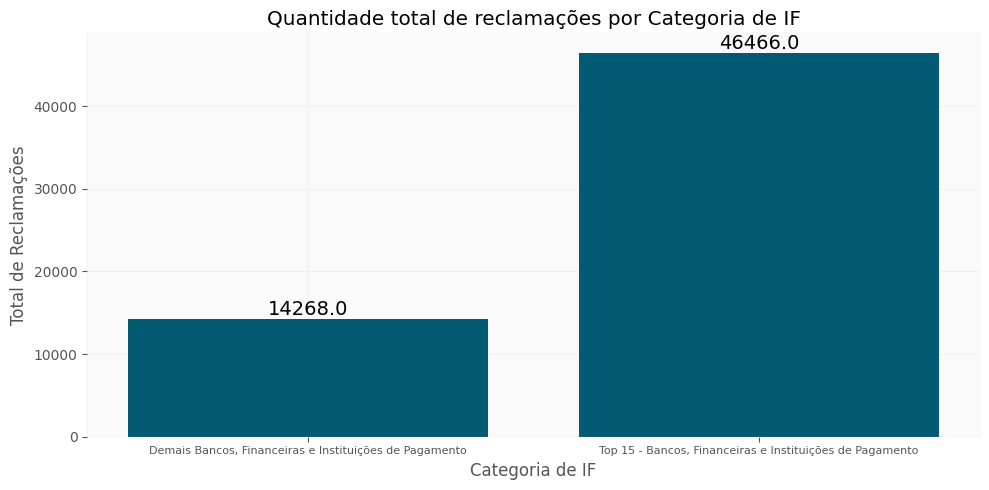

In [170]:
# Plotando as barras do total de reclamações 

# Função pyplot.bar()

# Prepara a figura (fig) e a área do gráfico (ax)
fig, ax = plt.subplots(figsize = (10,5))

# Define o título
plt.title('Quantidade total de reclamações por Categoria de IF')

# Define os rótulos dos eixos
plt.xlabel('Categoria de IF')
plt.ylabel('Total de Reclamações')

# Define a fonte do label das colunas
plt.xticks(ha = 'center', fontsize = 8)

# Plota o gráfico de barras
ax.bar(x = df_categoria_qtd_total['Categoria'], height = df_categoria_qtd_total['Quantidade total de reclamações'], color = corDefault)

# Acrescenta os valores sobre as barras
ax.bar_label(ax.containers[0], fmt="%.1f", fontsize = 14) # formatação do número com uma casa decimal

# Ajusta as margens do gráfico (para eliminar margens desnecessárias)
plt.tight_layout() 

# Armazena o gráfico (em diferentes formatos):
# - formatos vetoriais (NÃO perdem resolução quando redimensionados)
plt.savefig("barras-alfa.pdf")
plt.savefig("barras-alfa.svg")
# - formato rasterizado (perde resolução quando redimensionado)
plt.savefig("barras-alfa.png", dpi = 150, format = "png")

# Exibe o gráfico
plt.show()

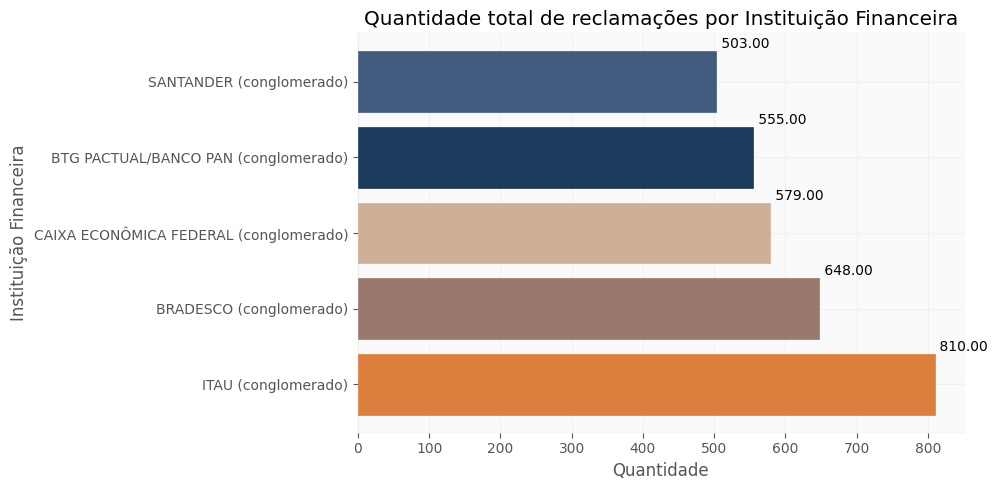

In [171]:
# Gráfico listando 5 maiores valores observados em "Quantidade total de reclamações"

# Prepara a figura (fig) e a área do gráfico (ax) com largura 10 e altura 5 (em polegadas)
fig, ax = plt.subplots(figsize = (10, 5))

# Define a altura das barras
bar_height = 0.5

# Cria dataframe ordenado por valor
df_ordem_valor = df.sort_values(['Quantidade total de reclamações'], ascending = False).head(5)

# Plota o gráfico de barras
b1 = ax.barh(y = df_ordem_valor['Instituição financeira'],
             width = df_ordem_valor['Quantidade total de reclamações'], 
             color = corDefault)

b1[0].set_color('#DC7E3C')
b1[1].set_color('#98796B')
b1[2].set_color('#CFAF96')
b1[3].set_color('#1A3B5C')
b1[4].set_color('#405B7E')


# Acrescenta os valores sobre as barras
for i, rect in enumerate(b1.patches):
    width = rect.get_width()
    ax.text(
        x = width + 0.5,                            # posição x
        y = rect.get_y() + rect.get_height(),       # posição y
        s = " {:.2f}".format(rect.get_width()),     # string com o valor
        ha = "left",                                # alinhamento na horizontal
        va = "bottom"                               # alinhamento na vertical
    )

# Acrescenta um título ao gráfico
plt.title('Quantidade total de reclamações por Instituição Financeira')

# Define os rótulos dos eixos
plt.xlabel('Quantidade')
plt.ylabel('Instituição Financeira')

# Ajusta as margens do gráfico (para eliminar margens desnecessárias)
plt.tight_layout() 

# Armazena o gráfico (em diferentes formatos):
# - formatos vetoriais (NÃO perdem resolução quando redimensionados)
plt.savefig("barras-horiz.pdf")
plt.savefig("barras-horiz.svg")
# - formato rasterizado (perde resolução quando redimensionado)
plt.savefig("barras-horiz.png", dpi = 150, format = "png")

# Exibe o gráfico
plt.show()

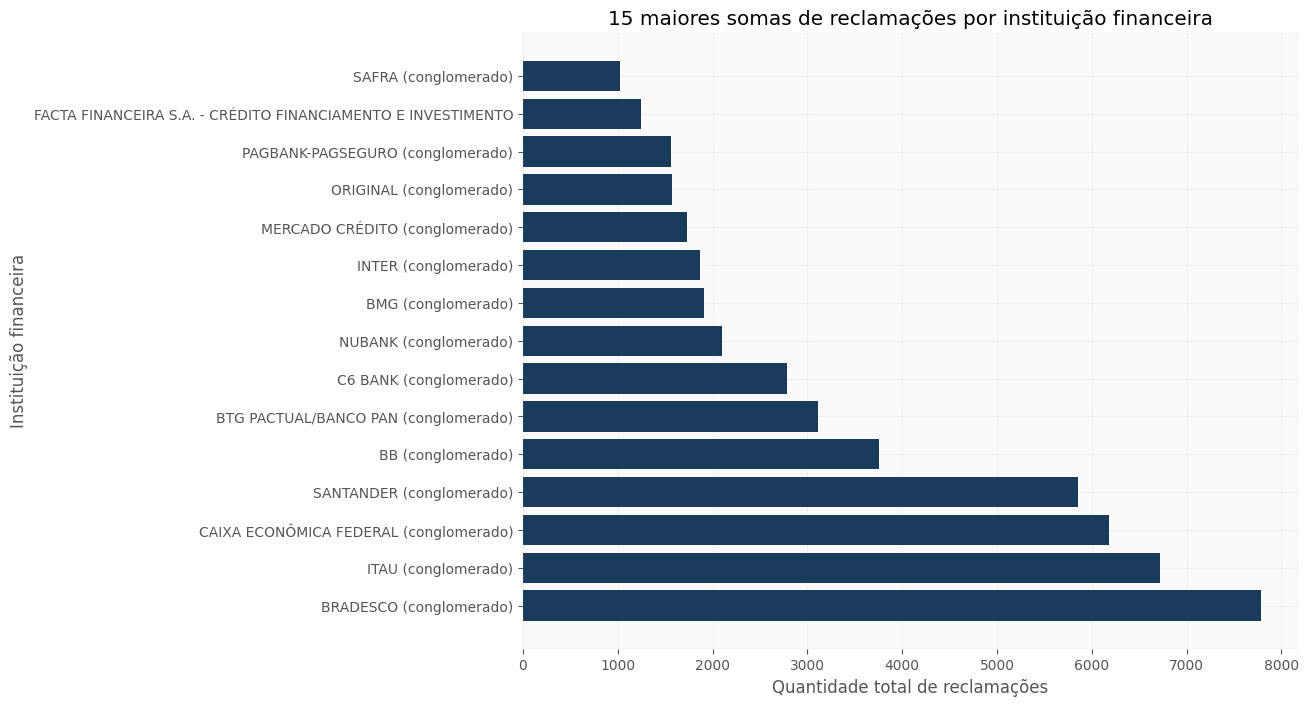

In [172]:
# seleciona as 15 maiores somas
df_top15 = df_groupby['Quantidade total de reclamações'].nlargest(15)

# plota o gráfico de barras horizontais
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(df_top15.index, df_top15.values, color='#1A3B5C')
ax.set_xlabel('Quantidade total de reclamações')
ax.set_ylabel('Instituição financeira')
ax.set_title('15 maiores somas de reclamações por instituição financeira')
plt.show()

### **5.2 Gráfico em Pizza**

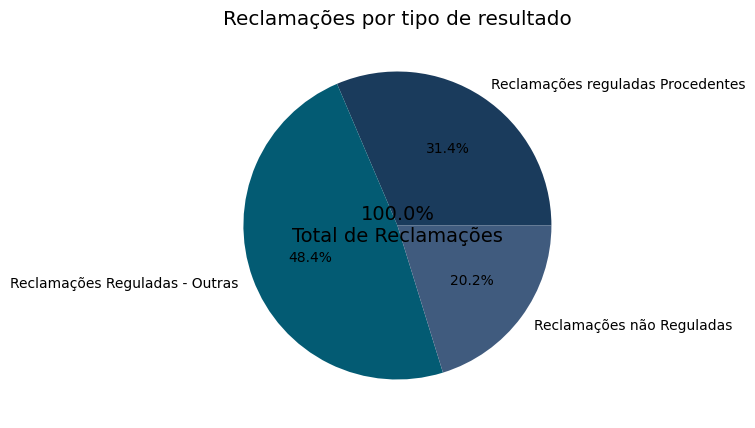

In [173]:
# calculando as somas totais dos atributos de reclamações reguladas procedentes, 
# reclamações reguladas - outras (não procedentes) e reclamações não reguladas 
soma_a = df['Quantidade de reclamações reguladas procedentes'].sum()
soma_b = df['Quantidade de reclamações reguladas - outras'].sum()
soma_c = df['Quantidade de reclamações não reguladas'].sum()
soma_d = df['Quantidade total de reclamações'].sum()

# calcula a soma do atributo D (que é a soma de A, B e C)
soma_abc = soma_a + soma_b + soma_c

# calcula o percentual de A+B+C=D
percentual = (soma_abc / soma_d) * 100

# cria as listas de valores e rótulos para o gráfico de pizza
valores = [soma_a, soma_b, soma_c]
rotulos = ['Reclamações reguladas Procedentes', 'Reclamações Reguladas - Outras', 'Reclamações não Reguladas']

# plota o gráfico de pizza
fig, ax = plt.subplots(figsize = (10,5))
ax.pie(valores, labels=rotulos, autopct='%1.1f%%', colors=cores)
ax.set_title('Reclamações por tipo de resultado')

# adiciona o texto com o percentual de A+B+C=D na parte central do gráfico
texto_central = ax.text(0, 0, f'{percentual:.1f}%\nTotal de Reclamações', ha='center', va='center', fontsize=14)

Das 60734 reclamações  feitas ao Banco Central no primeiro trimestre de 2023, 31,4% foram consideradas procedentes. 20,2% não são reguladas pelo Bacen ou não existe normativo vigente para sua análise. 48,4%, quase metade, foram consideradas improcedentes. Apenas as reclamações procedentes impactam a Instituição Financeira e são estas que geram punições ou sanções do órgão regulador.

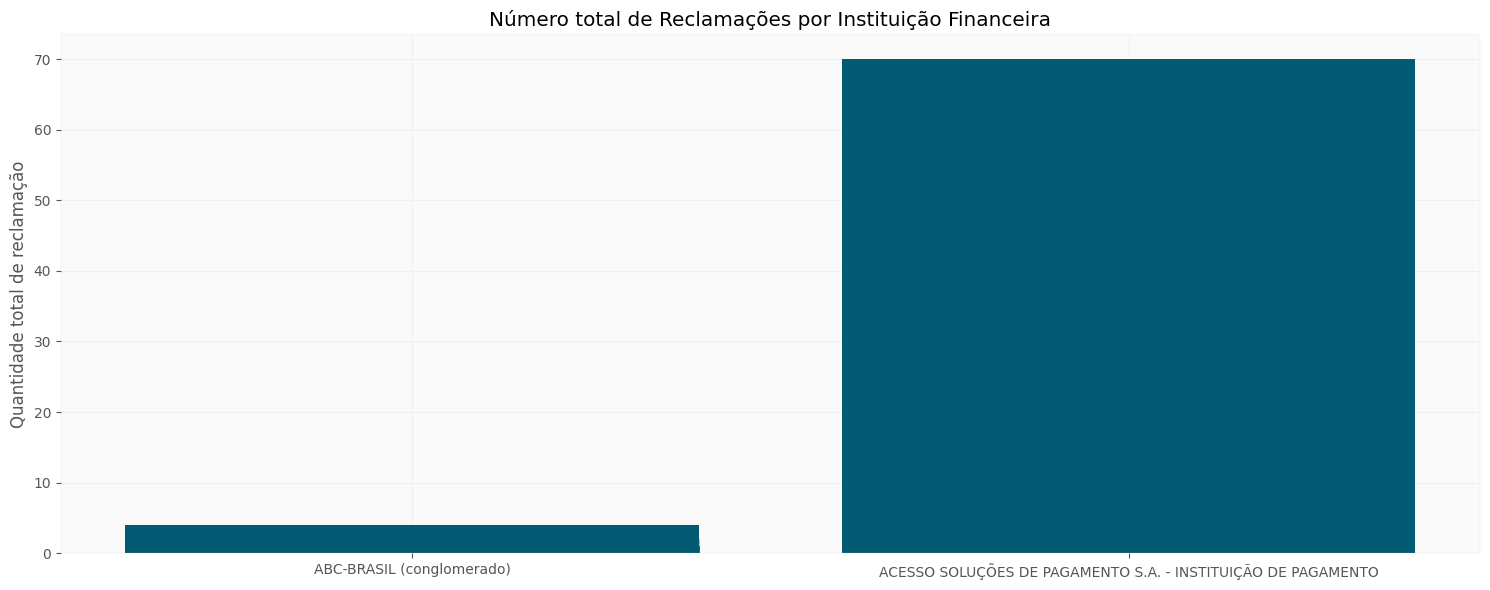

In [174]:
# 2: Plota as barras pelo número de reclamações de cada instituição
# Cria dataframe ordenado por valor
df_ordem_valor = df.sort_values('Quantidade total de reclamações', ascending = False)
df_ordem_valor = df.head(15)

# Prepara a figura (fig) e a área do gráfico (ax) com largura 15 e altura 6 (em polegadas)
fig, ax = plt.subplots(figsize = (15, 6))

# Plota o gráfico de barras
b1 = ax.bar(x = df_ordem_valor['Instituição financeira'], height = df_ordem_valor['Quantidade total de reclamações'], color = corDefault)

b1[0].set_color('#DC7E3C')
b1[1].set_color('#98796B')
b1[2].set_color('#CFAF96')
b1[3].set_color('#1A3B5C')
b1[4].set_color('#405B7E')

# Acrescenta um título ao gráfico
plt.title('Número total de Reclamações por Instituição Financeira')

# Define os rótulos dos eixos
# plt.xlabel('Quantidade') # como já está no título, não é necessário
plt.ylabel('Quantidade total de reclamação') # é importante esclarecer a unidade e a ordem de grandeza

# Ajusta as margens do gráfico (para eliminar margens desnecessárias)
plt.tight_layout() 

# Armazena o gráfico (em diferentes formatos):
# - formatos vetoriais (NÃO perdem resolução quando redimensionados)
plt.savefig("barras-valor-destaque.pdf")
plt.savefig("barras-valor-destaque.svg")
# - formato rasterizado (perde resolução quando redimensionado)
plt.savefig("barras-valor-destaque.png", dpi = 150, format = "png")

# Exibe o gráfico
plt.show()

### **5.3 Histograma**

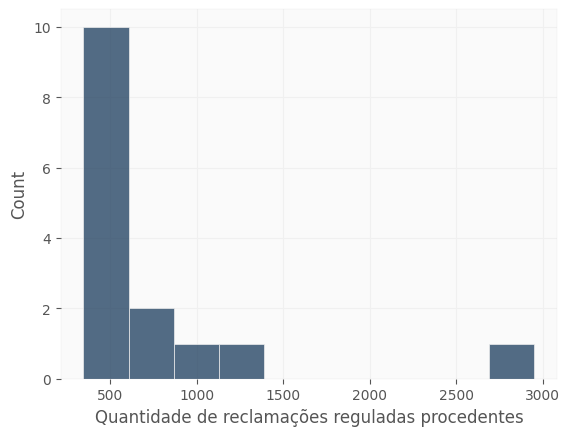

In [175]:
# Plote o histograma

sns.histplot(df_15_maiores_irregularidades, bins=10, color='#1A3B5C');

<Axes: xlabel='Quantidade de reclamações reguladas procedentes'>

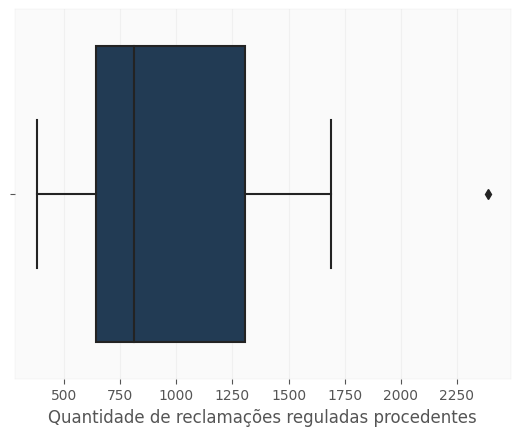

In [176]:
sns.boxplot(x=df_15_maiores_if_reclamadas, color='#1A3B5C')

### **5.3 Gráficos de dispersão**

Gráficos de dispersão não se aplicam neste caso, pois os valores observados estão no mesmo eixo de análise, não sendo possível correlacioná-los e observá-los desta forma.

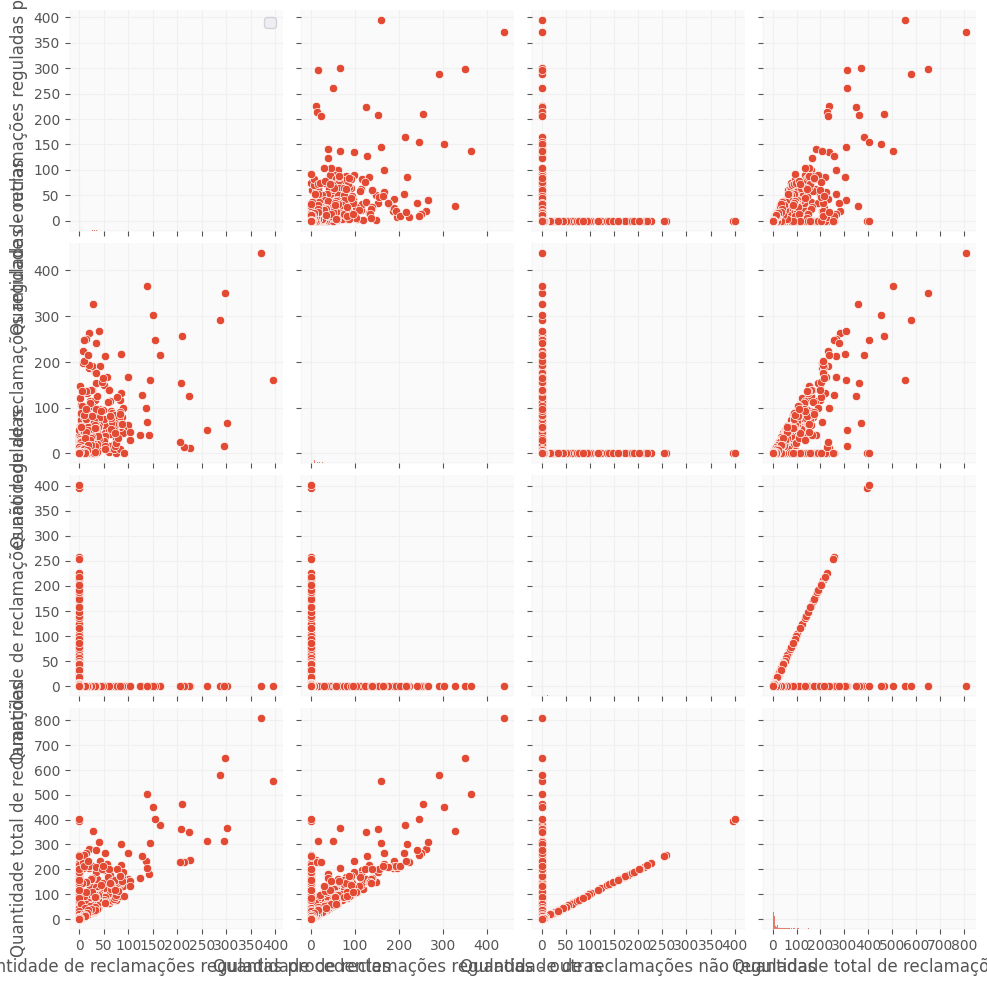

In [177]:
# Plota o pairplot com a paleta de cores personalizada
df_pairplot = sns.pairplot(df, palette='#1A3B5C')

# Define o tamanho da fonte para os subplots
sns.set(font_scale=0.2)

# Define o tamanho da fonte da legenda para 10
df_pairplot.axes[0,0].legend(fontsize=10)

# Exibe o gráfico
plt.show()

## **6. Pré-processamento**

In [178]:
# Criando uma cópia do dataset

variable_copy = df
print(variable_copy) 


            Ano Trimestre                                          Categoria  \
0    2023-01-01        1º  Demais Bancos, Financeiras e Instituições de P...   
1    2023-01-01        1º  Demais Bancos, Financeiras e Instituições de P...   
2    2023-01-01        1º  Demais Bancos, Financeiras e Instituições de P...   
3    2023-01-01        1º  Demais Bancos, Financeiras e Instituições de P...   
4    2023-01-01        1º  Demais Bancos, Financeiras e Instituições de P...   
...         ...       ...                                                ...   
3510 2023-01-01        1º  Demais Bancos, Financeiras e Instituições de P...   
3511 2023-01-01        1º  Demais Bancos, Financeiras e Instituições de P...   
3512 2023-01-01        1º  Demais Bancos, Financeiras e Instituições de P...   
3513 2023-01-01        1º  Demais Bancos, Financeiras e Instituições de P...   
3514 2023-01-01        1º  Demais Bancos, Financeiras e Instituições de P...   

           Instituição financeira  \
0 

### **6.1. Divisão do dataset em conjunto de treino e teste**

In [179]:
test_size = 0.3
seed=42

# Separação em conjuntos de treino e teste

# Como se trata de um dataset desbalanceado, vou utilizar a técnica de divisão
# com estratificação, com base na coluna "Categoria"

array = df.values
X = array[:,0:8]
y = df['Categoria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=seed, stratify=y)


### **6.2. Normalização e padronização**

In [180]:
# Criando subdataset apenas com dados numéricos

df_num = df.drop(columns=['Ano','Trimestre', 'Categoria', 'Instituição financeira', 'Irregularidade'])
df_num.head()

,Quantidade de reclamações reguladas procedentes,Quantidade de reclamações reguladas - outras,Quantidade de reclamações não reguladas,Quantidade total de reclamações
0,0,1,0,1
1,0,1,0,1
2,0,2,0,2
3,0,0,1,1
4,1,0,0,1


In [181]:
# Separando os valores do dataset em componentes de input(x) e output(y)
X = df_num.values[:,0:3]
Y = df_num.values[:,3]

In [182]:
# Normalizando os dados
rescaledX = MinMaxScaler().fit_transform(X)

# Exibindo os dados transformados
print('Dados Originais: \n\n', df_num.values)
print('\nDados Normalizados (não inclui a coluna class): \n\n', rescaledX)

Dados Originais: 

 [[0 1 0 1]
 [0 1 0 1]
 [0 2 0 2]
 ...
 [1 2 0 3]
 [0 0 2 2]
 [0 0 1 1]]

Dados Normalizados (não inclui a coluna class): 

 [[0.         0.0022779  0.        ]
 [0.         0.0022779  0.        ]
 [0.         0.00455581 0.        ]
 ...
 [0.00253165 0.00455581 0.        ]
 [0.         0.         0.00498753]
 [0.         0.         0.00249377]]


In [183]:
# Padronizando os dados
object = StandardScaler()
rescaledX = object.fit_transform(df_num)


# Exibindo os dados transformados
print('Dados Originais: \n\n', df_num.values)
print('\nDados Normalizados: \n\n', rescaledX)

Dados Originais: 

 [[0 1 0 1]
 [0 1 0 1]
 [0 2 0 2]
 ...
 [1 2 0 3]
 [0 0 2 2]
 [0 0 1 1]]

Dados Normalizados: 

 [[-0.25370394 -0.26182624 -0.18082923 -0.34233339]
 [-0.25370394 -0.26182624 -0.18082923 -0.34233339]
 [-0.25370394 -0.22623771 -0.18082923 -0.32130363]
 ...
 [-0.2069606  -0.22623771 -0.18082923 -0.30027387]
 [-0.25370394 -0.29741476 -0.07731734 -0.32130363]
 [-0.25370394 -0.29741476 -0.12907329 -0.34233339]]


### **6.3. Transformações categóricas**

In [184]:
df_cat =  pd.read_csv(url, sep=';', encoding='ISO-8859-1')
# df_cat.drop(columns=['Tipo', 'CNPJ IF', 'Unnamed: 11'], inplace=True)
df_cat.head()

,Ano,Trimestre,Categoria,Tipo,CNPJ IF,Instituição financeira,Irregularidade,Quantidade de reclamações reguladas procedentes,Quantidade de reclamações reguladas - outras,Quantidade de reclamações não reguladas,Quantidade total de reclamações,Unnamed: 11
0,2023,1º,"Demais Bancos, Financeiras e Instituições de P...",Conglomerado,,ABC-BRASIL (conglomerado),Cobrança irregular de tarifa relacionada a con...,0,1,0,1,NaN
1,2023,1º,"Demais Bancos, Financeiras e Instituições de P...",Conglomerado,,ABC-BRASIL (conglomerado),"Débito em conta não autorizado pelo cliente, o...",0,1,0,1,NaN
2,2023,1º,"Demais Bancos, Financeiras e Instituições de P...",Conglomerado,,ABC-BRASIL (conglomerado),Insatisfação com a resposta recebida da instit...,0,2,0,2,NaN
3,2023,1º,"Demais Bancos, Financeiras e Instituições de P...",Conglomerado,,ABC-BRASIL (conglomerado),Insatisfação com o atendimento prestado pelo S...,0,0,1,1,NaN
4,2023,1º,"Demais Bancos, Financeiras e Instituições de P...",Conglomerado,,ABC-BRASIL (conglomerado),Irregularidades relacionadas ao acompanhamento...,1,0,0,1,NaN


In [185]:
# verificando nulls no dataset
df_cat.isnull().sum()

Ano                                                   0
Trimestre                                             0
Categoria                                             0
Tipo                                                  0
CNPJ IF                                               0
Instituição financeira                                0
Irregularidade                                        0
Quantidade de reclamações reguladas procedentes       0
Quantidade de reclamações reguladas - outras          0
Quantidade de reclamações não reguladas               0
Quantidade total de reclamações                       0
Unnamed: 11                                        3515
dtype: int64

In [186]:
# exibindo as dimensões do dataset
print(df_cat.shape)

# eliminando linhas que tenham ALGUM valor missing
df_cat.drop(columns=['Unnamed: 11'], inplace=True)
df_cat.dropna(how='any', inplace=True) 

# exibindo as dimensões do dataset
print(df_cat.shape)

(3515, 12)
(3515, 11)


In [187]:
# separando o array em componentes de input e output
X = df_cat.values[:,0:10]
y = df_cat.values[:,10]

**Codificação Ordinal**

In [188]:
# ordinal encoding para os atributos X
encoded_X = OrdinalEncoder().fit_transform(X)

#exibindo os datos transformados
print('Atributos transformados:')
print(encoded_X[:5, :]) # 5 primeiras linhas, todas as colunas

Atributos transformados:
[[ 0.  0.  0.  1.  0.  0. 22.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0. 42.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0. 51.  0.  2.  0.]
 [ 0.  0.  0.  1.  0.  0. 53.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0. 71.  1.  0.  0.]]


**One-hot encoding**

In [189]:
# one hot encode para os atributos X
encoded_X = OneHotEncoder(sparse=False).fit_transform(X)

#exibindo dados transformados
print('Atributos transformados:')
print(encoded_X[:5, :]) # 5 primeiras linhas e todas colunas

Atributos transformados:
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


## **7. Conclusão**

Refletindo sobre o problema de negócio, verificamos que de aproximadamente 356,2 milhões de contas ativas, foram registradas apenas 60 mil reclamações. 16,84 a cada 100 mil contas. Este número pode ser pequeno se comparado ao total das contas mas muito grande, dependendo da quantidade de ocorrências e da base de clientes de um banco. Caberia, num próximo momento, cruzar estas informações 

Como dito anteriormente, a busca constante dos bancos e financeiras é evitar as ocorrências junto ao Bacen, tratar as reclamações ainda no atendimento (SAC ou Ouvidorias), entender as demandas dos clientes e agir conforme os normativos vigentes.

Muitas vezes existe falta de informação sobre a real competência do Bacen, gerando registros não tratáveis. O Banco Central poderia realizar campanhas de educação financeira, explicar melhor as normas, de forma didática (menos técnica), orientando para que o cliente possa identificar se sua demanda é normatizada pelo Bacen, evitando demora no atendimento e direcionando para o canal adequado (se for este o caso).

Do lado das instituições reguladas, cabe evitar abusos, cumprir as normas, buscar manter o sigilo dos clientes, das operações, explicar adequadamente as condições de produtos e serviços oferecidos. 

O setor financeiro é altamente lucrativo e competitivo, condizente com isso, deve manter um padrão de atendimento de excelência e priorizar o bom relacionamento junto aos clientes.  